
--- INICIANDO ANÁLISIS DE CONDUCCIÓN ---
1. Cargando modelo: modelo_pista_vectorial.h5...
✅ Modelo cargado correctamente.
2. Cargando dataset completo...
Found 1338 files belonging to 3 classes.
3. Aplicando recorte (Crop de 100px superiores)...
4. Evaluando el modelo (esto puede tardar un poco)...
✅ Evaluación terminada.

📊 Gráfico guardado: matriz_conduccion.png


2025-12-02 22:14:08.431161: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


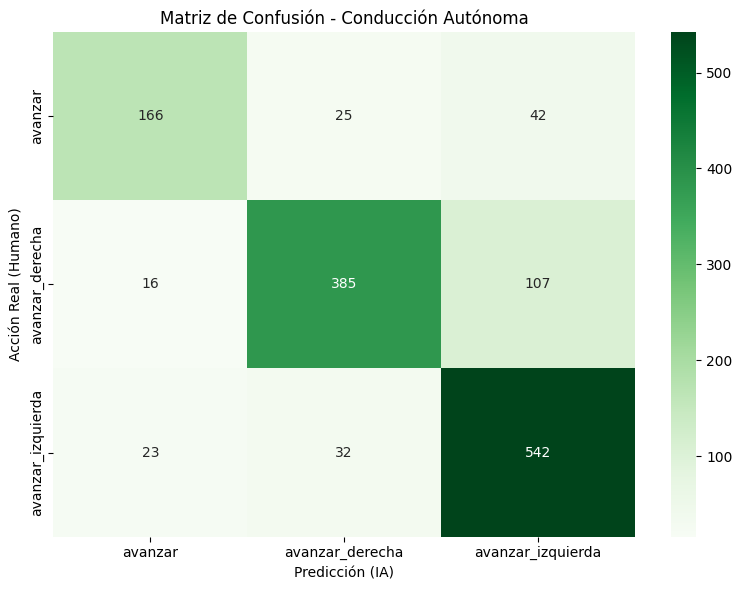

📊 Gráfico guardado: confianza_conduccion.png


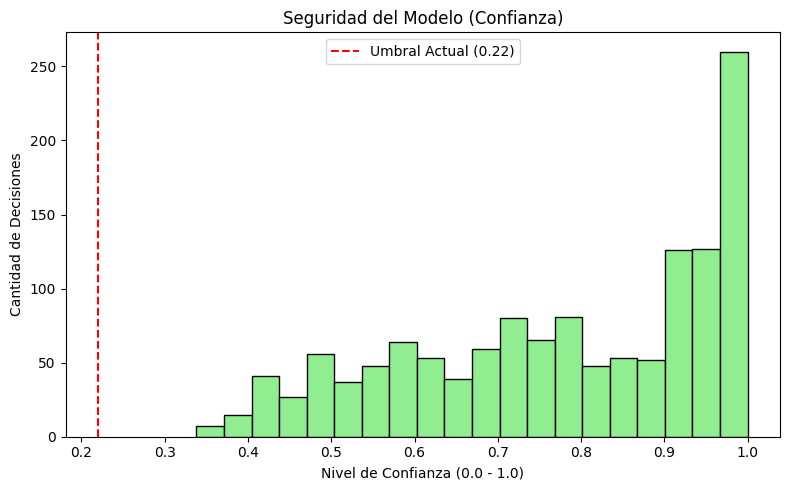


 REPORTE DE CLASIFICACIÓN
                   precision    recall  f1-score   support

          avanzar       0.81      0.71      0.76       233
  avanzar_derecha       0.87      0.76      0.81       508
avanzar_izquierda       0.78      0.91      0.84       597

         accuracy                           0.82      1338
        macro avg       0.82      0.79      0.80      1338
     weighted avg       0.82      0.82      0.82      1338



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

# ==========================================
# ⚙️ CONFIGURACIÓN (Debe coincidir con tu entrenamiento)
# ==========================================

# Rutas y Archivos
DATA_DIR = 'dataset_pista_vectorial' # Carpeta con tus fotos de conducción
MODEL_PATH = 'modelo_pista_vectorial.h5' # Tu modelo entrenado

# Dimensiones Originales
IMG_HEIGHT = 240
IMG_WIDTH = 320

# Recorte (Lo que ve la IA)
# IMPORTANTE: Debe ser igual a CROP_TOP en config.py y driving_training.py
CROP_TOP = 100
INPUT_HEIGHT = IMG_HEIGHT - CROP_TOP  # 140

BATCH_SIZE = 32

# Clases (En orden alfabético, como las lee Keras)
CLASS_NAMES = ['avanzar', 'avanzar_derecha', 'avanzar_izquierda']

# ==========================================

print("\n--- INICIANDO ANÁLISIS DE CONDUCCIÓN ---")

# 1. Cargar el Modelo
print(f"1. Cargando modelo: {MODEL_PATH}...")
if not os.path.exists(MODEL_PATH):
    print(f"❌ Error: No encuentro el archivo '{MODEL_PATH}'.")
    exit()

try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✅ Modelo cargado correctamente.")
except Exception as e:
    print(f"❌ Error cargando el modelo: {e}")
    exit()

# 2. Cargar Datos (Dataset COMPLETO)
# Usamos todo el dataset para ver la matriz de confusión global
print("2. Cargando dataset completo...")
if not os.path.exists(DATA_DIR):
    print(f"❌ Error: No encuentro la carpeta de datos '{DATA_DIR}'.")
    exit()

try:
    val_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=None, # <--- CLAVE: Cargamos todo para ver todas las clases
        seed=123, 
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=False # False para mantener orden y consistencia en pruebas
    )
except Exception as e:
    print(f"❌ Error cargando datos: {e}")
    exit()

# 3. Función de Preprocesamiento (Recorte)
def process_data(img, label):
    # Recorta: offset_height=100, offset_width=0, target_height=140, target_width=320
    img_cropped = tf.image.crop_to_bounding_box(img, CROP_TOP, 0, INPUT_HEIGHT, IMG_WIDTH)
    return img_cropped, label

print(f"3. Aplicando recorte (Crop de {CROP_TOP}px superiores)...")
val_ds_cropped = val_ds.map(process_data)

# 4. Generar Predicciones
print("4. Evaluando el modelo (esto puede tardar un poco)...")
y_true = []
y_pred = []
y_conf = []

# Iteramos por lotes
for images, labels in val_ds_cropped:
    preds = model.predict(images, verbose=0)
    
    # Etiquetas reales (índice del 1 en one-hot)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    
    # Predicciones (índice de la probabilidad más alta)
    y_pred.extend(np.argmax(preds, axis=1))
    
    # Confianza (valor de la probabilidad más alta)
    y_conf.extend(np.max(preds, axis=1))

print("✅ Evaluación terminada.")

# ==========================================
# 5. GENERACIÓN DE GRÁFICOS
# ==========================================

# GRÁFICO 1: Matriz de Confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Matriz de Confusión - Conducción Autónoma')
plt.ylabel('Acción Real (Humano)')
plt.xlabel('Predicción (IA)')
plt.tight_layout()
plt.savefig('matriz_conduccion.png')
print("\n📊 Gráfico guardado: matriz_conduccion.png")
plt.show()

# GRÁFICO 2: Histograma de Confianza
plt.figure(figsize=(8, 5))
plt.hist(y_conf, bins=20, color='lightgreen', edgecolor='black')
plt.title('Seguridad del Modelo (Confianza)')
plt.xlabel('Nivel de Confianza (0.0 - 1.0)')
plt.ylabel('Cantidad de Decisiones')
plt.axvline(x=0.22, color='red', linestyle='--', label='Umbral Actual (0.22)')
plt.legend()
plt.tight_layout()
plt.savefig('confianza_conduccion.png')
print("📊 Gráfico guardado: confianza_conduccion.png")
plt.show()

# REPORTE DE TEXTO
print("\n" + "="*40)
print(" REPORTE DE CLASIFICACIÓN")
print("="*40)
# labels=[0, 1, 2] fuerza a mostrar las 3 clases aunque alguna falte en los resultados
print(classification_report(y_true, y_pred, labels=[0, 1, 2], target_names=CLASS_NAMES, zero_division=0))